In [9]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
# from qiskit.tools.visualization import plot_histogram
from IPython.display import clear_output
from scipy.sparse.linalg import eigs
from scipy import sparse
import math

num_q = 10
J = 1
Delta = 1.5
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

List_2 = []
op = ""
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

H = SparsePauliOp.sum([H1,H2])

# Ordering e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
Hmat = sparse.csr_matrix(Hmat)

e, v = eigs(Hmat,k=20)
#e, v = LA.eig(Hmat)
min_index = np.argmin(e)
v_min = v[:,min_index]
ground_e = np.min(e)
print(H[-1])
print(np.min(e))
print(H.size)
print(H.paulis[0])
print(H)

SparsePauliOp(['IIIIIIIIIX'],
              coeffs=[1.5+0.j])
(-16.535254946759206-1.31305397054855e-16j)
19
IIIIIIIIZZ
SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZZI', 'IIIIIIZZII', 'IIIIIZZIII', 'IIIIZZIIII', 'IIIZZIIIII', 'IIZZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'XIIIIIIIII', 'IXIIIIIIII', 'IIXIIIIIII', 'IIIXIIIIII', 'IIIIXIIIII', 'IIIIIXIIII', 'IIIIIIXIII', 'IIIIIIIXII', 'IIIIIIIIXI', 'IIIIIIIIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j,
 1.5+0.j, 1.5+0.j, 1.5+0.j])


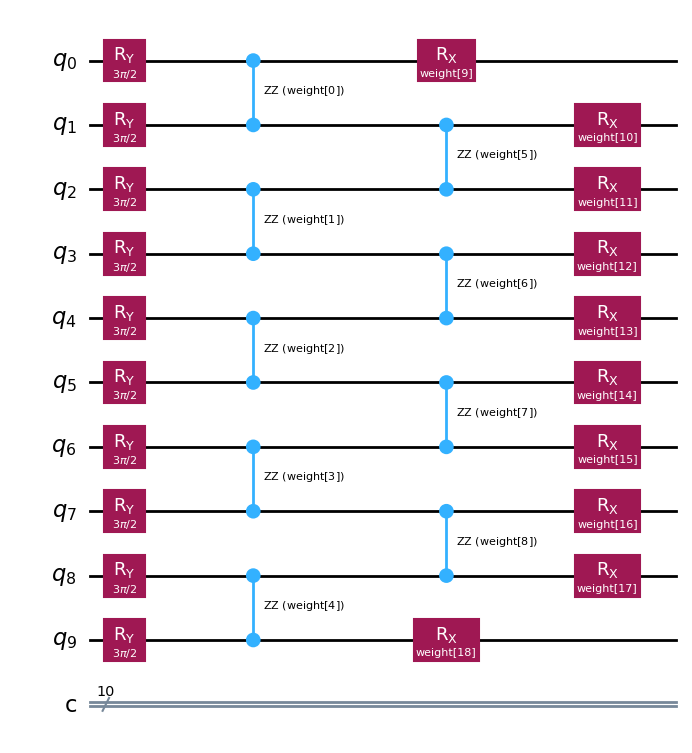

In [13]:
"""circuit construction"""

# HVA: hamiltonian variational ansatz
# Exploring Entanglement and Optimization within the Hamiltonian Variational Ansatz
# https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020319

# num_q = 5
layer = 1
# layer = 20 # default value
num_p = (2*num_q-1)*layer
weights = ParameterVector("weight",num_p)

def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    for j in range(num_q):
        circ.ry(np.pi/2*3,j)
    for i in range(layer):
        for j in range(int(num_q/2)):
            circ.rzz(weights[j+(2*num_q-1)*i],2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.rzz(weights[j+int(num_q/2)+(2*num_q-1)*i], 2*j+1, 2*j+2)
        for j in range(num_q):
            circ.rx(weights[j+num_q-1+(2*num_q-1)*i], j)
    return circ

qc=circuit_ex(weights)
qc.draw('mpl')

In [ ]:
simulator = AerSimulator()

def weight_converter(WEIGHTS):
    weight_long = []
    for j in range(2*layer):
        if j % 2 == 0:
            for i in range(num_q-1): # num_q-1
                # rzz 每层只有num_q-1个参数，所以这里只添加num_q-1个参数
                weight_long.append(WEIGHTS[j])
        else: # rx 每次添加num_q个参数
            for i in range(num_q):
                weight_long.append(WEIGHTS[j])
    
    return weight_long


def estimate_loss(WEIGHT_long, SHOTS):

    estimate = 0
    qc = circuit_ex(WEIGHT_long)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        for j in range(num_q-1):
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1
    estimate = J*estimate/SHOTS
    
    estimate_1 = 0
    qc = circuit_ex(WEIGHT_long)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta*estimate_1/SHOTS

    return estimate+estimate_1

def parameter_shift(WEIGHTS, INDEX, SHOTS):
    WEIGHT_long = weight_converter(WEIGHTS)
    identity = np.identity(num_p)
    g = 0
    if INDEX % 2 == 0: #ZZ layer
        #INDEX_new = int(INDEX/2)*(2*num_q-1)
        #direction_index = np.pi/2 *identity[:,INDEX_new]
        INDEX_new = int(INDEX/2)*(2*num_q-1) + np.random.randint(0,num_q-1,1)
        direction_index = np.pi/2 *identity[:,INDEX_new]
        g_p = estimate_loss((WEIGHT_long+direction_index.flatten()), SHOTS)
        g_m = estimate_loss((WEIGHT_long-direction_index.flatten()), SHOTS)
        g = (num_q-1)*0.5*(g_p-g_m)   
    else: ## X sum
        #INDEX_new = int(np.floor(INDEX/2))*(2*num_q-1)+num_q-1
        #direction_index = np.pi/2 *identity[:,INDEX]
        INDEX_new = int(np.floor(INDEX/2))*(2*num_q-1)+num_q-1 + np.random.randint(0,num_q,1)
        direction_index = np.pi/2 *identity[:,INDEX_new]
        g_p = estimate_loss((WEIGHT_long+direction_index.flatten()), SHOTS)
        g_m = estimate_loss((WEIGHT_long-direction_index.flatten()), SHOTS)
        g = num_q*0.5*(g_p-g_m) ## parameter shift rule with eigenvalues +-0.5

    return g

def expectation_loss(WEIGHTS):
    WEIGHT_long = weight_converter(WEIGHTS)
    qc = circuit_ex(WEIGHT_long)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)

    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    WEIGHT_long = weight_converter(WEIGHTS)
    qc = circuit_ex(WEIGHT_long)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    
    return np.absolute(np.vdot(psi,v_min))**2

Loss and Fidelity: -10.337879984941042 0.16189498624899523


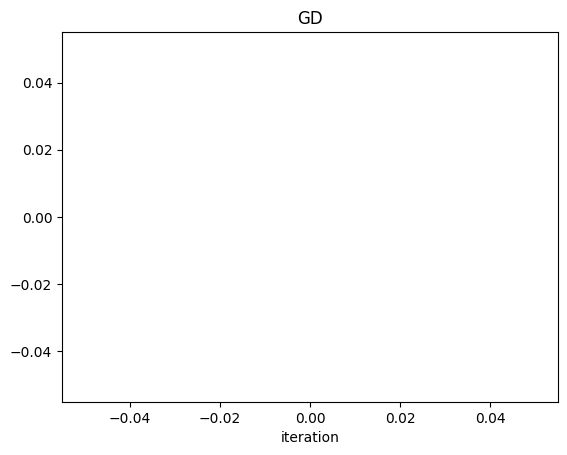

KeyboardInterrupt: 

In [ ]:
"""optimization phase"""



"""initialization of weights"""



mat = scipy.io.loadmat('w0')
w0 = mat['w0']


num_p_real = 2*layer
# num_p = (2*num_q-1)*layer

initial_weights = np.zeros(num_p_real) #np.ones(num_p)
initial_weights[:10] = w0.flatten()


T = 20
n_shot = 1000


num_results = 1
cost_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
fidelity_mat = np.empty((0,T), int)
F = 0
iteration = 0
loss = 0 

for l in range(num_results):
    cost = []
    cost_f = []
    Weights = []
    weights = initial_weights
    iteration = 0
    while iteration < T:
        a = 0.006
        iteration = iteration + 1
        gradient = []
        for j in range(num_p_real):
            index = j
            partial_gradient = parameter_shift(weights, index, n_shot)
            gradient.append(partial_gradient)
        gradient = np.array(gradient)
        weights = weights - a*gradient
        Weights.append(weights)
        F = fidelity(weights)
        loss = expectation_loss(weights)
        clear_output(wait=True)
        print('Loss and Fidelity:',loss, fidelity(weights))
        # plt.plot(cost)
        # plt.xlabel('iteration')
        # plt.title('GD')
        # plt.show()
        cost.append(loss.flatten())
        cost_f.append(F.flatten())    
    
    Cost = np.asarray(cost)
    WEIGHTS = np.asarray(Weights)
    FIDELITY = np.asarray(cost_f)
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis = 0)
    
scipy.io.savemat('gd_loss_1.mat', {'gd_loss_1': cost_mat})
scipy.io.savemat('gd_weight_1.mat', {'gd_weight_1': weight_mat})
scipy.io.savemat('gd_fidelity_1.mat', {'gd_fidelity_1': fidelity_mat})


plt.plot(cost)
plt.title('GD')
plt.xlabel('iteration')
plt.show()
